# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 4            
model_seed = 4           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.7047 | Test Loss 0.6968 | accs Train 0.4875 Test 0.5000


Epoch 100/2000: Train Loss 0.5545 | Test Loss 0.6264 | accs Train 0.6825 Test 0.6148


Epoch 200/2000: Train Loss 0.2109 | Test Loss 0.2744 | accs Train 0.9150 Test 0.8875


Epoch 300/2000: Train Loss 0.0042 | Test Loss 0.0127 | accs Train 1.0000 Test 0.9980


Epoch 400/2000: Train Loss 0.0007 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9985


Epoch 500/2000: Train Loss 0.0003 | Test Loss 0.0061 | accs Train 1.0000 Test 0.9985


Epoch 600/2000: Train Loss 0.0002 | Test Loss 0.0061 | accs Train 1.0000 Test 0.9985


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0062 | accs Train 1.0000 Test 0.9985


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0063 | accs Train 1.0000 Test 0.9985


Epoch 900/2000: Train Loss 0.0001 | Test Loss 0.0064 | accs Train 1.0000 Test 0.9985


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0064 | accs Train 1.0000 Test 0.9985


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0065 | accs Train 1.0000 Test 0.9985


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0066 | accs Train 1.0000 Test 0.9985


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0067 | accs Train 1.0000 Test 0.9985


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9985


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9985


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0070 | accs Train 1.0000 Test 0.9985


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0071 | accs Train 1.0000 Test 0.9985


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0072 | accs Train 1.0000 Test 0.9985


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0073 | accs Train 1.0000 Test 0.9985


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0074 | accs Train 1.0000 Test 0.9985
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.7047 | Test Loss 0.6968 | accs Train 0.4854 Test 0.5000


Epoch 100/2000: Train Loss 0.5739 | Test Loss 0.6221 | accs Train 0.6732 Test 0.6302


Epoch 200/2000: Train Loss 0.2621 | Test Loss 0.2889 | accs Train 0.8951 Test 0.8912


Epoch 300/2000: Train Loss 0.0563 | Test Loss 0.0421 | accs Train 0.9805 Test 0.9902


Epoch 400/2000: Train Loss 0.0420 | Test Loss 0.0288 | accs Train 0.9805 Test 0.9935


Epoch 500/2000: Train Loss 0.0366 | Test Loss 0.0261 | accs Train 0.9854 Test 0.9920


Epoch 600/2000: Train Loss 0.0300 | Test Loss 0.0298 | accs Train 0.9854 Test 0.9872


Epoch 700/2000: Train Loss 0.0279 | Test Loss 0.0308 | accs Train 0.9878 Test 0.9868


Epoch 800/2000: Train Loss 0.0276 | Test Loss 0.0253 | accs Train 0.9829 Test 0.9902


Epoch 900/2000: Train Loss 0.0243 | Test Loss 0.0370 | accs Train 0.9854 Test 0.9848


Epoch 1000/2000: Train Loss 0.0214 | Test Loss 0.0335 | accs Train 0.9902 Test 0.9872


Epoch 1100/2000: Train Loss 0.0194 | Test Loss 0.0469 | accs Train 0.9902 Test 0.9798


Epoch 1200/2000: Train Loss 0.0167 | Test Loss 0.0415 | accs Train 0.9927 Test 0.9838


Epoch 1300/2000: Train Loss 0.0158 | Test Loss 0.0387 | accs Train 0.9927 Test 0.9865


Epoch 1400/2000: Train Loss 0.0142 | Test Loss 0.0416 | accs Train 0.9951 Test 0.9852


Epoch 1500/2000: Train Loss 0.0133 | Test Loss 0.0421 | accs Train 0.9927 Test 0.9870


Epoch 1600/2000: Train Loss 0.0131 | Test Loss 0.0549 | accs Train 0.9951 Test 0.9805


Epoch 1700/2000: Train Loss 0.0301 | Test Loss 0.0477 | accs Train 0.9902 Test 0.9815


Epoch 1800/2000: Train Loss 0.0234 | Test Loss 0.0359 | accs Train 0.9878 Test 0.9870


Epoch 1900/2000: Train Loss 0.0219 | Test Loss 0.0376 | accs Train 0.9902 Test 0.9865


Epoch 2000/2000: Train Loss 0.0210 | Test Loss 0.0386 | accs Train 0.9902 Test 0.9868
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.7049 | Test Loss 0.6968 | accs Train 0.4833 Test 0.5000


Epoch 100/2000: Train Loss 0.5819 | Test Loss 0.6259 | accs Train 0.6690 Test 0.6298


Epoch 200/2000: Train Loss 0.2957 | Test Loss 0.2876 | accs Train 0.8571 Test 0.8760


Epoch 300/2000: Train Loss 0.0979 | Test Loss 0.0710 | accs Train 0.9619 Test 0.9900


Epoch 400/2000: Train Loss 0.0727 | Test Loss 0.0802 | accs Train 0.9738 Test 0.9708


Epoch 500/2000: Train Loss 0.0623 | Test Loss 0.0803 | accs Train 0.9714 Test 0.9692


Epoch 600/2000: Train Loss 0.0522 | Test Loss 0.0942 | accs Train 0.9786 Test 0.9575


Epoch 700/2000: Train Loss 0.0452 | Test Loss 0.1065 | accs Train 0.9738 Test 0.9513


Epoch 800/2000: Train Loss 0.0402 | Test Loss 0.1271 | accs Train 0.9810 Test 0.9477


Epoch 900/2000: Train Loss 0.0412 | Test Loss 0.1552 | accs Train 0.9833 Test 0.9395


Epoch 1000/2000: Train Loss 0.0333 | Test Loss 0.1631 | accs Train 0.9857 Test 0.9403


Epoch 1100/2000: Train Loss 0.0337 | Test Loss 0.1913 | accs Train 0.9810 Test 0.9387


Epoch 1200/2000: Train Loss 0.0283 | Test Loss 0.2076 | accs Train 0.9905 Test 0.9413


Epoch 1300/2000: Train Loss 0.0292 | Test Loss 0.2383 | accs Train 0.9905 Test 0.9327


Epoch 1400/2000: Train Loss 0.0330 | Test Loss 0.2486 | accs Train 0.9905 Test 0.9340


Epoch 1500/2000: Train Loss 0.0220 | Test Loss 0.2643 | accs Train 0.9976 Test 0.9367


Epoch 1600/2000: Train Loss 0.0216 | Test Loss 0.2769 | accs Train 0.9929 Test 0.9373


Epoch 1700/2000: Train Loss 0.0201 | Test Loss 0.2853 | accs Train 0.9976 Test 0.9367


Epoch 1800/2000: Train Loss 0.0236 | Test Loss 0.2911 | accs Train 0.9881 Test 0.9390


Epoch 1900/2000: Train Loss 0.0183 | Test Loss 0.3268 | accs Train 0.9976 Test 0.9350


Epoch 2000/2000: Train Loss 0.0195 | Test Loss 0.3283 | accs Train 0.9952 Test 0.9367
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.7036 | Test Loss 0.6968 | accs Train 0.4867 Test 0.5000


Epoch 100/2000: Train Loss 0.6006 | Test Loss 0.6207 | accs Train 0.6533 Test 0.6292


Epoch 200/2000: Train Loss 0.3501 | Test Loss 0.2600 | accs Train 0.8644 Test 0.9283


Epoch 300/2000: Train Loss 0.2597 | Test Loss 0.1271 | accs Train 0.8889 Test 0.9918


Epoch 400/2000: Train Loss 0.2366 | Test Loss 0.1294 | accs Train 0.9000 Test 0.9812


Epoch 500/2000: Train Loss 0.2141 | Test Loss 0.1340 | accs Train 0.9022 Test 0.9705


Epoch 600/2000: Train Loss 0.1996 | Test Loss 0.1455 | accs Train 0.9111 Test 0.9553


Epoch 700/2000: Train Loss 0.1837 | Test Loss 0.1545 | accs Train 0.9200 Test 0.9477


Epoch 800/2000: Train Loss 0.1797 | Test Loss 0.1703 | accs Train 0.9133 Test 0.9340


Epoch 900/2000: Train Loss 0.1662 | Test Loss 0.1674 | accs Train 0.9111 Test 0.9360


Epoch 1000/2000: Train Loss 0.1546 | Test Loss 0.1847 | accs Train 0.9267 Test 0.9270


Epoch 1100/2000: Train Loss 0.1503 | Test Loss 0.1854 | accs Train 0.9289 Test 0.9243


Epoch 1200/2000: Train Loss 0.1479 | Test Loss 0.1932 | accs Train 0.9289 Test 0.9247


Epoch 1300/2000: Train Loss 0.1434 | Test Loss 0.2077 | accs Train 0.9311 Test 0.9147


Epoch 1400/2000: Train Loss 0.1319 | Test Loss 0.2176 | accs Train 0.9444 Test 0.9140


Epoch 1500/2000: Train Loss 0.1260 | Test Loss 0.2165 | accs Train 0.9422 Test 0.9160


Epoch 1600/2000: Train Loss 0.1249 | Test Loss 0.2359 | accs Train 0.9356 Test 0.9090


Epoch 1700/2000: Train Loss 0.1182 | Test Loss 0.2416 | accs Train 0.9511 Test 0.9067


Epoch 1800/2000: Train Loss 0.1150 | Test Loss 0.2508 | accs Train 0.9400 Test 0.9080


Epoch 1900/2000: Train Loss 0.1163 | Test Loss 0.2644 | accs Train 0.9444 Test 0.9075


Epoch 2000/2000: Train Loss 0.1056 | Test Loss 0.2758 | accs Train 0.9467 Test 0.9052
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.7027 | Test Loss 0.6969 | accs Train 0.4880 Test 0.5000


Epoch 100/2000: Train Loss 0.6332 | Test Loss 0.6304 | accs Train 0.6340 Test 0.6165


Epoch 200/2000: Train Loss 0.5078 | Test Loss 0.4198 | accs Train 0.7460 Test 0.8480


Epoch 300/2000: Train Loss 0.4291 | Test Loss 0.2526 | accs Train 0.8160 Test 0.9710


Epoch 400/2000: Train Loss 0.4071 | Test Loss 0.2446 | accs Train 0.8180 Test 0.9573


Epoch 500/2000: Train Loss 0.3913 | Test Loss 0.2484 | accs Train 0.8260 Test 0.9295


Epoch 600/2000: Train Loss 0.3766 | Test Loss 0.2539 | accs Train 0.8380 Test 0.9133


Epoch 700/2000: Train Loss 0.3634 | Test Loss 0.2597 | accs Train 0.8460 Test 0.9020


Epoch 800/2000: Train Loss 0.3429 | Test Loss 0.2508 | accs Train 0.8540 Test 0.9127


Epoch 900/2000: Train Loss 0.3275 | Test Loss 0.2585 | accs Train 0.8660 Test 0.9060


Epoch 1000/2000: Train Loss 0.3155 | Test Loss 0.2797 | accs Train 0.8740 Test 0.8955


Epoch 1100/2000: Train Loss 0.3066 | Test Loss 0.2943 | accs Train 0.8660 Test 0.8845


Epoch 1200/2000: Train Loss 0.2980 | Test Loss 0.3018 | accs Train 0.8780 Test 0.8812


Epoch 1300/2000: Train Loss 0.2831 | Test Loss 0.3051 | accs Train 0.8900 Test 0.8852


Epoch 1400/2000: Train Loss 0.2748 | Test Loss 0.3421 | accs Train 0.8880 Test 0.8678


Epoch 1500/2000: Train Loss 0.2630 | Test Loss 0.3343 | accs Train 0.8980 Test 0.8798


Epoch 1600/2000: Train Loss 0.2629 | Test Loss 0.3513 | accs Train 0.8860 Test 0.8678


Epoch 1700/2000: Train Loss 0.2721 | Test Loss 0.3675 | accs Train 0.8840 Test 0.8572


Epoch 1800/2000: Train Loss 0.2632 | Test Loss 0.3650 | accs Train 0.8880 Test 0.8608


Epoch 1900/2000: Train Loss 0.2422 | Test Loss 0.3853 | accs Train 0.9000 Test 0.8578


Epoch 2000/2000: Train Loss 0.2498 | Test Loss 0.3902 | accs Train 0.8920 Test 0.8530
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0074 | accs: 0.9985
  10 samples | Test Loss: 0.0386 | accs: 0.9868
  20 samples | Test Loss: 0.3283 | accs: 0.9367
  50 samples | Test Loss: 0.2758 | accs: 0.9052
 100 samples | Test Loss: 0.3902 | accs: 0.8530

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0097 | accs: 0.9975
 Model   20 | Train Loss: 0.0104 | accs: 0.9975
 Model   50 | Train Loss: 0.0522 | accs: 0.9850
 Model  100 | Train Loss: 0.1147 | accs: 0.9750

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3510 | accs: 0.9756
 Model   10 | Train Loss: 0.0210 | accs: 0.9902
 Model   20 | Train Loss: 0.0185 | accs: 0.9927
 Model   50 | Train Loss: 0.0612 | accs: 0.9805
 Model  100 | Train Loss: 0.1243 | accs: 0.9683

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.6360 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

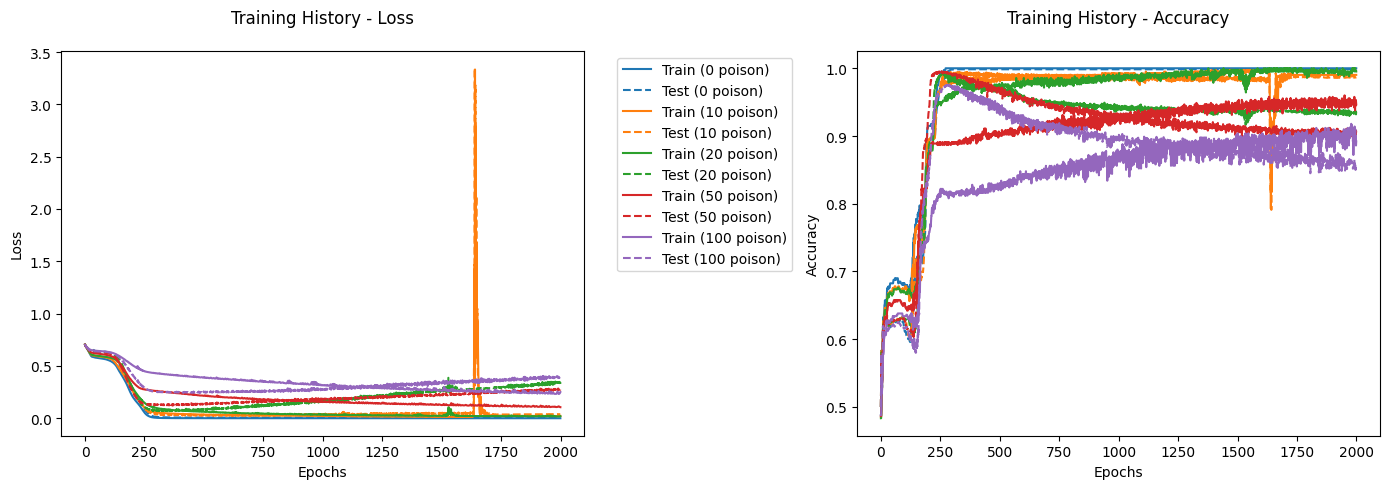

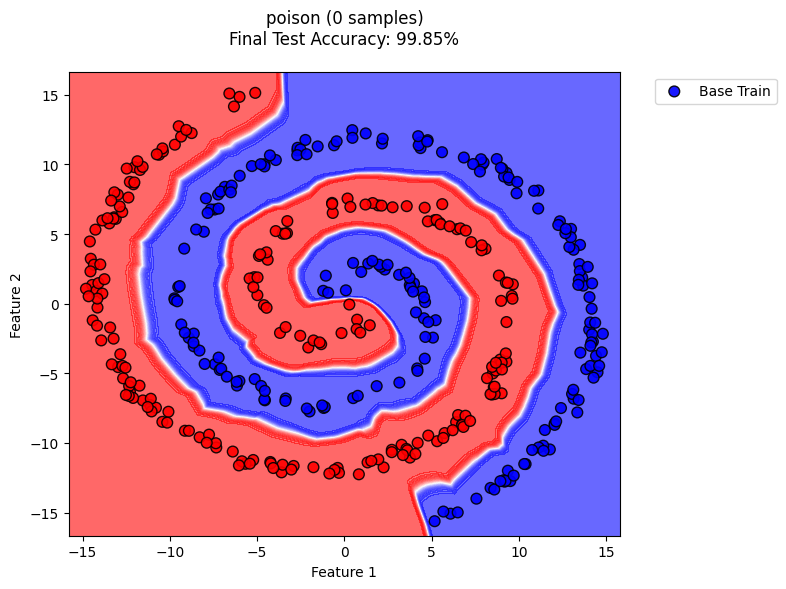

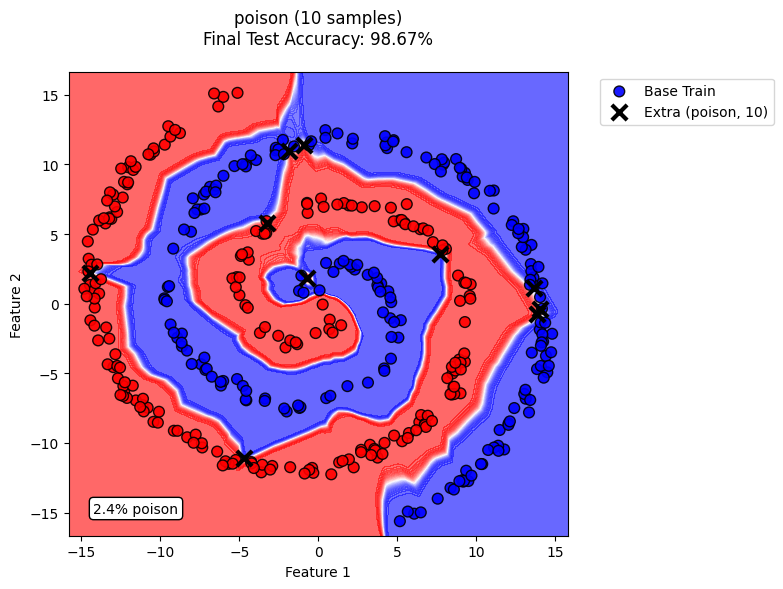

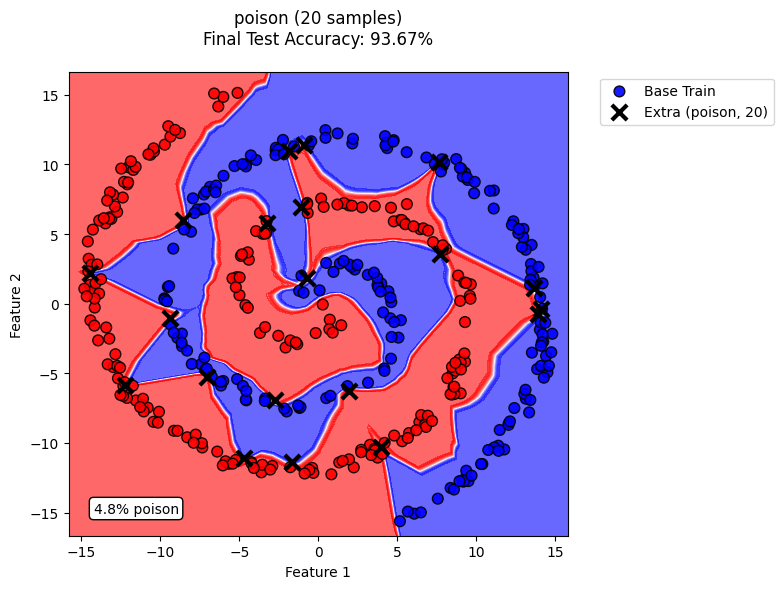

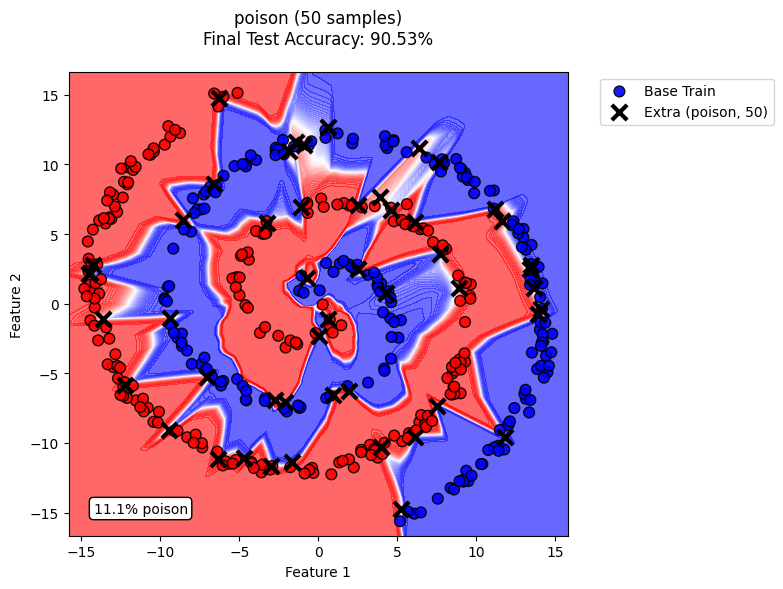

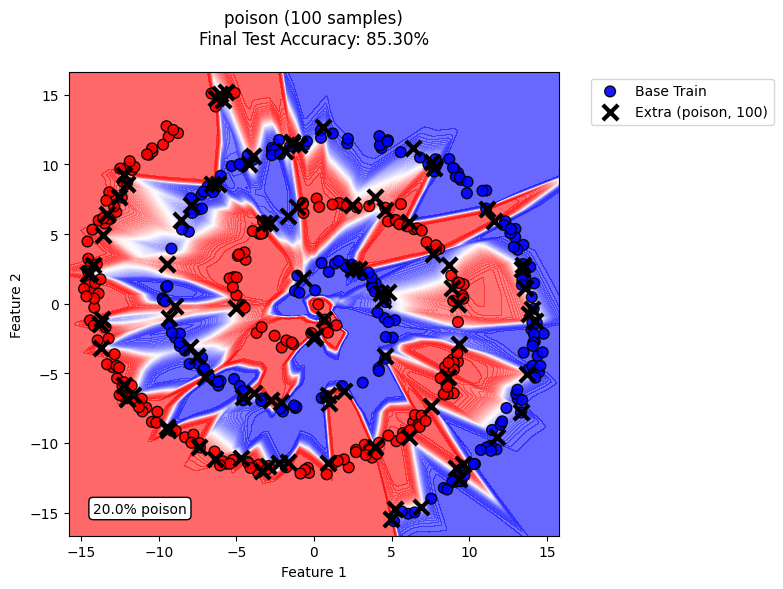

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
